# VideoMAE with Layer-wise LR Decay + Advanced Augmentation

**Experiment**: Test Layer-wise Learning Rate Decay (0.75) + **Mixup, Cutmix, RandAugment**.

**Key Differences**:
- **Augmentation**: Added RandAugment (2, 9), Mixup (0.8), Cutmix (1.0).
- **Loss**: Switched to SoftTargetCrossEntropy to handle mixed labels.
- **Layer-wise LR Decay**: 0.75 (lower layers learn slower).
- **Config**: Batch=20, Epochs=10, LR=5e-4.

**Note**: Mixup/Cutmix significantly hardens the training task. Training accuracy might drop, but validation robustness should increase.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification, get_cosine_schedule_with_warmup
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import gc
import time

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

E0000 00:00:1768815266.626036     529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768815266.632631     529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


## 1. Configuration

In [2]:
# Paths
PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'

# Model
MODEL_CKPT = 'MCG-NJU/videomae-base-finetuned-kinetics'
NUM_FRAMES = 16
IMG_SIZE = 224
RESIZE_SIZE = 256

# Training Config
BATCH_SIZE = 20        # Fit 15GB VRAM
EPOCHS = 20            # Quick test
BASE_LR = 5e-4         # High LR for head
LAYER_DECAY = 0.75     # Paper recommendation
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.1

# Augmentation Config
MIXUP_ALPHA = 0.8
CUTMIX_ALPHA = 1.0
MIXUP_PROB = 1.0       # Probability to apply Mixup OR Cutmix
SWITCH_PROB = 0.5      # Probability to switch between Mixup and Cutmix
LABEL_SMOOTHING = 0.1
RANDAUG_N = 2
RANDAUG_M = 9

# Normalization (ImageNet)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

print(f"Model: {MODEL_CKPT}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Layer Decay: {LAYER_DECAY}")
print(f"Augmentation: Mixup({MIXUP_ALPHA}), Cutmix({CUTMIX_ALPHA}), RandAug({RANDAUG_N},{RANDAUG_M})")

Model: MCG-NJU/videomae-base-finetuned-kinetics
Batch Size: 20
Layer Decay: 0.75
Augmentation: Mixup(0.8), Cutmix(1.0), RandAug(2,9)


## 2. Augmentation Utilities (Mixup/Cutmix)

In [3]:
def rand_bbox(size, lam):
    """Generate random bounding box for Cutmix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def mixup_cutmix_fn(inputs, targets, num_classes, mixup_alpha=0.8, cutmix_alpha=1.0, prob=1.0, switch_prob=0.5):
    """
    Applies Mixup or Cutmix to a batch.
    inputs: (B, T, C, H, W)
    targets: (B)
    """
    inputs = inputs.float()
    targets = targets.long()
    
    if np.random.rand() > prob:
        return inputs, F.one_hot(targets, num_classes).float()
    
    batch_size = inputs.size(0)
    indices = torch.randperm(batch_size).to(inputs.device)
    shuffled_inputs = inputs[indices]
    shuffled_targets = targets[indices]
    
    # Decide between Mixup and Cutmix
    use_cutmix = np.random.rand() < switch_prob
    
    if use_cutmix:
        # CUTMIX
        lam = np.random.beta(cutmix_alpha, cutmix_alpha)
        # Inputs shape: (B, T, C, H, W)
        # Cutmix applies same box to all frames in the video usually, or per frame.
        # For efficiency and consistency, applying same box to all frames.
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.shape[1:], lam)
        
        # Adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size(-1) * inputs.size(-2)))
        
        inputs[:, :, :, bbx1:bbx2, bby1:bby2] = shuffled_inputs[:, :, :, bbx1:bbx2, bby1:bby2]
    else:
        # MIXUP
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        inputs = inputs * lam + shuffled_inputs * (1 - lam)
    
    # Prepare soft targets
    targets_one_hot = F.one_hot(targets, num_classes).float()
    shuffled_targets_one_hot = F.one_hot(shuffled_targets, num_classes).float()
    
    mixed_targets = targets_one_hot * lam + shuffled_targets_one_hot * (1 - lam)
    
    return inputs, mixed_targets

class SoftTargetCrossEntropy(nn.Module):
    def __init__(self):
        super(SoftTargetCrossEntropy, self).__init__()

    def forward(self, x, target):
        loss = torch.sum(-target * F.log_softmax(x, dim=-1), dim=-1)
        return loss.mean()

## 3. Layer-wise LR Decay Logic

In [4]:
def get_layer_id_for_videomae(name, num_layers=12):
    if 'cls_token' in name or 'mask_token' in name: return 0
    elif 'patch_embed' in name or 'pos_embed' in name: return 0
    elif 'encoder.layer' in name:
        parts = name.split('.')
        for i, part in enumerate(parts):
            if part == 'layer' and i + 1 < len(parts):
                return int(parts[i + 1]) + 1
        return num_layers
    elif 'layernorm' in name.lower() or 'fc_norm' in name: return num_layers
    else: return num_layers + 1

def get_layer_decay_params(model, base_lr, weight_decay, layer_decay=0.75, num_layers=12):
    param_groups = {}
    for name, param in model.named_parameters():
        if not param.requires_grad: continue
        layer_id = get_layer_id_for_videomae(name, num_layers)
        scale = layer_decay ** (num_layers + 1 - layer_id)
        lr = base_lr * scale
        wd = 0.0 if ('bias' in name or 'norm' in name.lower()) else weight_decay
        group_key = f"layer_{layer_id}_wd_{wd}"
        if group_key not in param_groups:
            param_groups[group_key] = {"params": [], "lr": lr, "weight_decay": wd, "layer_id": layer_id}
        param_groups[group_key]["params"].append(param)
    return list(param_groups.values())

def print_lr_summary(param_groups):
    print("\nLayer-wise LR Summary:")
    layer_lrs = {}
    for group in param_groups:
        lid = group.get('layer_id', 'unknown')
        if lid not in layer_lrs: layer_lrs[lid] = group['lr']
    for lid in sorted(layer_lrs.keys()):
        label = 'Head' if lid == 13 else f'Layer {lid}' if lid > 0 else 'Embedding'
        print(f"{label:15s}: LR = {layer_lrs[lid]:.2e}")

## 4. Dataset Classes (with RandAugment)

In [5]:
class VideoDataset(Dataset):
    def __init__(self, root, num_frames=16, is_train=True):
        self.root = Path(root)
        self.num_frames = num_frames
        self.is_train = is_train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = self.root / cls
            for video_dir in sorted([d for d in cls_dir.iterdir() if d.is_dir()]):
                self.samples.append((video_dir, self.class_to_idx[cls]))
        
        # RandAugment for training
        if self.is_train:
            self.rand_aug = T.RandAugment(num_ops=RANDAUG_N, magnitude=RANDAUG_M)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_dir, label = self.samples[idx]
        frame_paths = sorted(video_dir.glob('*.jpg'))
        total = len(frame_paths)
        indices = torch.linspace(0, total - 1, self.num_frames).long()
        frames = [TF.resize(Image.open(frame_paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        
        if self.is_train:
            # 1. Consistent Spatial Transform (Crop/Flip)
            i, j, h, w = T.RandomResizedCrop.get_params(frames[0], (0.8, 1.0), (0.75, 1.33))
            do_flip = random.random() > 0.5
            
            processed = []
            for img in frames:
                # Apply RandAugment (per frame, independent)
                img = self.rand_aug(img)
                
                # Apply consistent Crop & Flip
                img = TF.resized_crop(img, i, j, h, w, (IMG_SIZE, IMG_SIZE))
                if do_flip:
                    img = TF.hflip(img)
                
                img = TF.normalize(TF.to_tensor(img), MEAN, STD)
                processed.append(img)
        else:
            processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        
        return torch.stack(processed), label

class TestDataset(Dataset):
    def __init__(self, root, num_frames=16):
        self.root = Path(root)
        self.num_frames = num_frames
        self.samples = sorted([(d, int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x: x[1])
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        video_dir, video_id = self.samples[idx]
        frame_paths = sorted(video_dir.glob('*.jpg'))
        indices = torch.linspace(0, len(frame_paths) - 1, self.num_frames).long()
        frames = [TF.resize(Image.open(frame_paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        return torch.stack(processed), video_id

## 5. Training Loop (with Mixup)

In [6]:
def train_epoch(model, loader, optimizer, scheduler, scaler, device, criterion, num_classes):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False, dynamic_ncols=True)
    
    for videos, labels in pbar:
        videos = videos.to(device)
        labels = labels.to(device)
        
        # Apply Mixup/Cutmix
        videos, mixed_labels = mixup_cutmix_fn(
            videos, labels, num_classes,
            mixup_alpha=MIXUP_ALPHA,
            cutmix_alpha=CUTMIX_ALPHA,
            prob=MIXUP_PROB,
            switch_prob=SWITCH_PROB
        )
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(videos)
            logits = outputs.logits
            loss = criterion(logits, mixed_labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        # Metrics (using original labels for rough accuracy)
        batch_size = labels.size(0)
        # Note: Accuracy with mixup is less meaningful, but useful to track
        batch_acc = (logits.argmax(1) == labels).float().mean().item()
        
        total_loss += loss.item() * batch_size
        correct += (logits.argmax(1) == labels).sum().item()
        total += batch_size
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{batch_acc:.4f}"})
    
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, classes, gt_dict, device):
    model.eval()
    predictions = []
    print("Evaluating...")
    for videos, video_ids in tqdm(loader, desc="Inference", leave=False):
        videos = videos.to(device)
        logits = model(videos).logits
        preds = logits.argmax(1).cpu().tolist()
        predictions.extend(zip(video_ids.tolist(), preds))
    y_true = [gt_dict[str(vid)] for vid, _ in predictions]
    y_pred = [classes[p] for _, p in predictions]
    return accuracy_score(y_true, y_pred)

## 6. Execution Setup

In [7]:
# Download labels
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q

# Load datasets
train_dataset = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, is_train=True)
test_dataset = TestDataset(PATH_DATA_TEST, NUM_FRAMES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Ground Truth
gt_df = pd.read_csv('test_labels.csv')
gt_dict = dict(zip(gt_df['id'].astype(str), gt_df['class']))

# Model
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True,
    num_frames=NUM_FRAMES
).to(DEVICE)

# Optimizer & Scheduler
param_groups = get_layer_decay_params(model, BASE_LR, WEIGHT_DECAY, LAYER_DECAY)
optimizer = torch.optim.AdamW(param_groups)
print_lr_summary(param_groups)

num_training_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(num_training_steps * WARMUP_RATIO), num_training_steps)
scaler = torch.amp.GradScaler()

# Loss
criterion = SoftTargetCrossEntropy()

# Training Loop
print("="*60)
print("STARTING TRAINING: Layer Decay + Mixup + RandAug")
print("="*60)

history = []
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    
    loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, criterion, len(train_dataset.classes))
    test_acc = evaluate(model, test_loader, train_dataset.classes, gt_dict, DEVICE)
    
    epoch_time = time.time() - start_time
    eta = epoch_time * (EPOCHS - epoch)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_aug_decay.pt')
        
    status = " >>> BEST" if test_acc >= best_acc else ""
    print(f"Ep {epoch}/{EPOCHS}: Loss={loss:.4f}, TrAcc={train_acc:.4f}, TeAcc={test_acc:.4f}{status} | Time: {epoch_time//60:.0f}m{epoch_time%60:.0f}s")
    
    history.append({'epoch': epoch, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc})
    gc.collect(); torch.cuda.empty_cache()

# Save
df = pd.DataFrame(history)
df.to_csv('results_aug.csv', index=False)
print(f"Experiment Complete. Best Acc: {best_acc:.4f}")

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Layer-wise LR Summary:
Embedding      : LR = 1.19e-05
Layer 1        : LR = 1.58e-05
Layer 2        : LR = 2.11e-05
Layer 3        : LR = 2.82e-05
Layer 4        : LR = 3.75e-05
Layer 5        : LR = 5.01e-05
Layer 6        : LR = 6.67e-05
Layer 7        : LR = 8.90e-05
Layer 8        : LR = 1.19e-04
Layer 9        : LR = 1.58e-04
Layer 10       : LR = 2.11e-04
Layer 11       : LR = 2.81e-04
Layer 12       : LR = 3.75e-04
Head           : LR = 5.00e-04
STARTING TRAINING: Layer Decay + Mixup + RandAug


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 1/20: Loss=2.8166, TrAcc=0.2957, TeAcc=0.6745 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 2/20: Loss=1.7080, TrAcc=0.4726, TeAcc=0.7294 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 3/20: Loss=1.6226, TrAcc=0.5200, TeAcc=0.7314 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 4/20: Loss=1.4300, TrAcc=0.5340, TeAcc=0.7647 >>> BEST | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 5/20: Loss=1.3515, TrAcc=0.5660, TeAcc=0.7882 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 6/20: Loss=1.2595, TrAcc=0.5909, TeAcc=0.7961 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 7/20: Loss=1.1721, TrAcc=0.6010, TeAcc=0.8059 >>> BEST | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 8/20: Loss=1.1318, TrAcc=0.6240, TeAcc=0.8118 >>> BEST | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 9/20: Loss=1.0207, TrAcc=0.6438, TeAcc=0.8176 >>> BEST | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 10/20: Loss=0.9890, TrAcc=0.6109, TeAcc=0.8137 | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 11/20: Loss=0.9394, TrAcc=0.5813, TeAcc=0.8216 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 12/20: Loss=0.8832, TrAcc=0.6301, TeAcc=0.8294 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 13/20: Loss=0.7999, TrAcc=0.6558, TeAcc=0.8255 | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 14/20: Loss=0.7882, TrAcc=0.6548, TeAcc=0.8333 >>> BEST | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 15/20: Loss=0.7592, TrAcc=0.6869, TeAcc=0.8392 >>> BEST | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 16/20: Loss=0.7288, TrAcc=0.6301, TeAcc=0.8314 | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 17/20: Loss=0.7229, TrAcc=0.6226, TeAcc=0.8451 >>> BEST | Time: 10m38s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 18/20: Loss=0.6963, TrAcc=0.6487, TeAcc=0.8353 | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 19/20: Loss=0.6699, TrAcc=0.6704, TeAcc=0.8353 | Time: 10m37s


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating...


Inference:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 20/20: Loss=0.6938, TrAcc=0.6454, TeAcc=0.8353 | Time: 10m37s
Experiment Complete. Best Acc: 0.8451


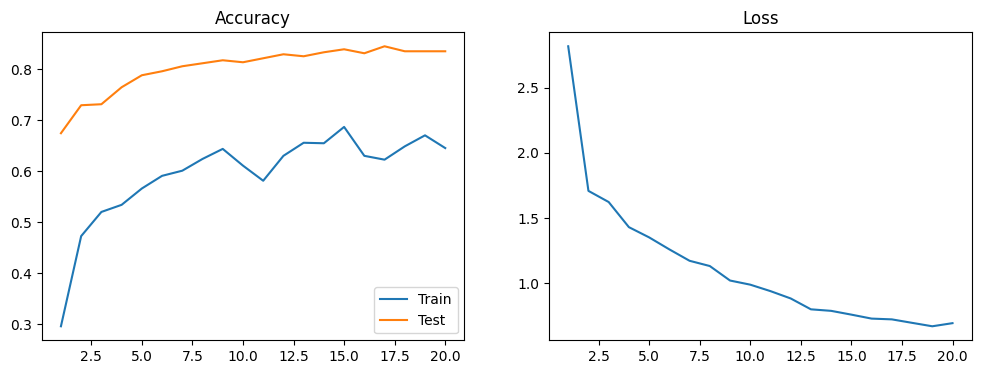

In [8]:
import matplotlib.pyplot as plt
if 'df' in locals():
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(df['epoch'], df['train_acc'], label='Train')
    ax[0].plot(df['epoch'], df['test_acc'], label='Test')
    ax[0].legend(); ax[0].set_title('Accuracy')
    ax[1].plot(df['epoch'], df['loss']); ax[1].set_title('Loss')
    plt.savefig('curves_aug.png')
    plt.show()